In [1]:
% matplotlib inline

#### Week 3: Baseline Models

In [14]:
import gdal
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from scipy.stats.stats import pearsonr
from geotiling import GeoProps
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from skimage.feature import hog, daisy
from skimage import data, color, exposure
from sklearn import metrics

gdal.SetCacheMax(2**30) # 1 GB
sns.set_style("ticks")
sns.set_palette(sns.color_palette("dark", 8))

**Baseline: regression against night-time light intensity**

In [3]:
!head -n 20 ../data/bucket_files.txt 

gs://dfd-poverty/Bangladesh_CE_2011.csv
gs://dfd-poverty/Bangladesh_CE_2015.csv
gs://dfd-poverty/F182013.v4c_web.stable_lights.avg_vis.tif
gs://dfd-poverty/F182013.v4c_web.stable_lights.avg_vis.tif.gz
gs://dfd-poverty/India_pov_pop.csv
gs://dfd-poverty/Readme_poverty.rtf
gs://dfd-poverty/SVDNB_npp_20150101-20151231_75N060E_vcm-orm-ntl_v10_c201701311200.avg_rade9.tif
gs://dfd-poverty/bangladesh_2015_test.csv
gs://dfd-poverty/bangladesh_2015_train.csv
gs://dfd-poverty/bangladesh_2015_valid.csv
gs://dfd-poverty/india_sampled.csv
gs://dfd-poverty/l8_median_bangladesh_2011_multiband_500x500_1.0.tif
gs://dfd-poverty/l8_median_bangladesh_2011_multiband_500x500_10.0.tif
gs://dfd-poverty/l8_median_bangladesh_2011_multiband_500x500_100.0.tif
gs://dfd-poverty/l8_median_bangladesh_2011_multiband_500x500_1000.0.tif
gs://dfd-poverty/l8_median_bangladesh_2011_multiband_500x500_1001.0.tif
gs://dfd-poverty/l8_median_bangladesh_2011_multiband_500x500_1002.0.tif
gs://dfd-poverty/l8_median_bangladesh_2011

In [4]:
bucket_files = open("../data/staff_bucket_files.txt").readlines()

In [41]:
bangladesh_2011 = pd.read_csv("../data/bucket/Bangladesh_CE_2011_pc.csv")
bangladesh_2015 = pd.read_csv("../data/bucket/Bangladesh_CE_2015_pc.csv")
india = pd.read_csv("../data/bucket/India_pov_pop.csv")

In [1]:
bangladesh_2011 = bangladesh_2011[bangladesh_2011["totexp_m_pc"] > 0]
bangladesh_2015 = bangladesh_2015[bangladesh_2015["totexp_m_pc"] > 0]
india = india[india["secc_cons_per_cap_scaled"] > 0]

NameError: name 'bangladesh_2011' is not defined

Text(0,0.5,'Normalized density')

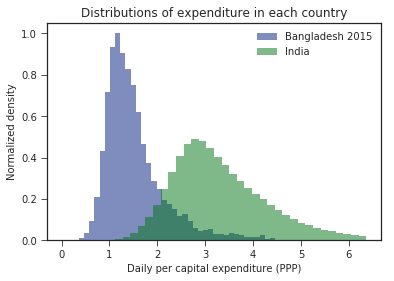

In [43]:
plt.hist((bangladesh_2015["totexp_m_pc"] / 30 / 23)[(bangladesh_2015["totexp_m_pc"] / 30 / 23) < np.percentile((bangladesh_2015["totexp_m_pc"] / 30 / 23)[~np.isnan(bangladesh_2015["totexp_m_pc"])], 98)], alpha=0.5, normed=True, label="Bangladesh 2015", bins=40)
plt.hist(((india["secc_cons_per_cap_scaled"] / 365 / 16 * 1.05)[(india["secc_cons_per_cap_scaled"] / 365 / 16 * 1.05) < np.percentile((india["secc_cons_per_cap_scaled"] / 365 / 16 * 1.05)[~np.isnan(india["secc_cons_per_cap_scaled"])], 98)])[~np.isnan(india["secc_cons_per_cap_scaled"])], alpha=0.5, normed=True, label="India", bins=40)
# plt.hist((bangladesh_2011["totexp_m_pc"] / 30 / 23)[(bangladesh_2011["totexp_m_pc"] / 30 / 23) < np.percentile((bangladesh_2011["totexp_m_pc"] / 30 / 23)[~np.isnan(bangladesh_2011["totexp_m_pc"])], 98)], alpha=0.5, normed=True, label="Bangladesh 2011")
plt.legend()
plt.title("Distributions of expenditure in each country")
plt.xlabel("Daily per capital expenditure (PPP)")
plt.ylabel("Normalized density")

In [44]:
mu = {
  "bangladesh": np.mean(bangladesh_2015["totexp_m_pc"]),
  "india": np.mean(india["secc_cons_per_cap_scaled"])
}

In [45]:
std = {
  "bangladesh": np.std(bangladesh_2015["totexp_m_pc"]),
  "india": np.std(india["secc_cons_per_cap_scaled"])
}

In [46]:
print(mu)
print(std)

{'india': 18893.349349611133, 'bangladesh': 1124.5325549266486}
{'india': 6968.5784399108061, 'bangladesh': 734.8297964668609}


In [47]:
bangladesh_2015["totexp_m_pc"] = (bangladesh_2015["totexp_m_pc"] - mu["bangladesh"]) / std["bangladesh"]
india["secc_cons_per_cap_scaled"] = (india["secc_cons_per_cap_scaled"] - mu["india"]) / std["india"]

Text(0,0.5,'Normalized density')

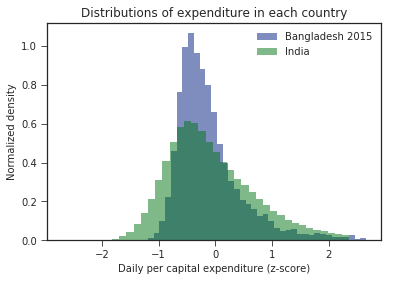

In [48]:
plt.hist((bangladesh_2015["totexp_m_pc"])[(bangladesh_2015["totexp_m_pc"]) < np.percentile((bangladesh_2015["totexp_m_pc"])[~np.isnan(bangladesh_2015["totexp_m_pc"])], 98)], alpha=0.5, normed=True, label="Bangladesh 2015", bins=40)
plt.hist(((india["secc_cons_per_cap_scaled"])[(india["secc_cons_per_cap_scaled"]) < np.percentile((india["secc_cons_per_cap_scaled"])[~np.isnan(india["secc_cons_per_cap_scaled"])], 98)])[~np.isnan(india["secc_cons_per_cap_scaled"])], alpha=0.5, normed=True, label="India", bins=40)
plt.legend()
plt.title("Distributions of expenditure in each country")
plt.xlabel("Daily per capital expenditure (z-score)")
plt.ylabel("Normalized density")

In [49]:
india_ids = [s.split("_")[-1].split(".")[0] for s in bucket_files if "s1_median_india_vis" in s]

In [50]:
india_ids = set(map(lambda s: int(s), india_ids))

In [51]:
len(india_ids)

564530

In [52]:
np.mean(india["id"].isin(india_ids))

0.99388706565066132

In [53]:
india_sampled = india[india["id"].isin(india_ids)]

In [54]:
india_sampled.shape

(564504, 15)

In [55]:
# india_sampled.to_csv("../data/india_sampled.csv")

**Separate train/test/validation datasets**

In [407]:
# villages = list(set(bangladesh_2015["Village"]))

In [408]:
# indices = list(range(len(villages)))

In [409]:
# random.shuffle(villages)

In [410]:
# N = len(villages)
# i, j = round(N * 0.75), round(N * 0.9)

In [411]:
# bangladesh_2015_train = bangladesh_2015[bangladesh_2015["Village"].isin(villages[:i])]
# bangladesh_2015_valid = bangladesh_2015[bangladesh_2015["Village"].isin(villages[i:j])]
# bangladesh_2015_test = bangladesh_2015[bangladesh_2015["Village"].isin(villages[j:])]

In [412]:
# bangladesh_2015_train.to_csv("../data/bangladesh_2015_train.csv")
# bangladesh_2015_valid.to_csv("../data/bangladesh_2015_valid.csv")
# bangladesh_2015_test.to_csv("../data/bangladesh_2015_test.csv")

In [56]:
bangladesh_2015_train = pd.read_csv("../data/bangladesh_2015_train.csv")
bangladesh_2015_valid = pd.read_csv("../data/bangladesh_2015_valid.csv")
bangladesh_2015_test = pd.read_csv("../data/bangladesh_2015_test.csv")

In [51]:
def count_unique(col):
  return len(set(col))

In [52]:
count_unique(bangladesh_2015["District"]), count_unique(bangladesh_2015["Upazila"]), count_unique(bangladesh_2015["Union"])

(64, 293, 348)

In [54]:
# shuffled = india_sampled.sample(frac=1.0)

In [55]:
# N = len(shuffled)
# i, j = round(N * 0.75), round(N * 0.9)

# india_train = shuffled.iloc[:i,:]
# india_valid = shuffled.iloc[i:j,:]
# india_test = shuffled.iloc[j:,:]

In [56]:
# india_train.to_csv("../data/india_train.csv")
# india_valid.to_csv("../data/india_valid.csv")
# india_test.to_csv("../data/india_test.csv")

In [58]:
india_train = pd.read_csv("../data/india_train.csv")
india_valid = pd.read_csv("../data/india_valid.csv")
india_test = pd.read_csv("../data/india_test.csv")

**VIIRS dataset**

Resolution: 15 arc-seconds [2x that of DMSP].

Date: 2015.

In [59]:
lights_tif = "../data/bucket/SVDNB_npp_20150101-20151231_75N060E_vcm-orm-ntl_v10_c201701311200.avg_rade9.tif"

In [60]:
viirs_tif = gdal.Open(lights_tif)

In [61]:
viirs_props = GeoProps()
viirs_props.import_geogdal(viirs_tif)

In [62]:
viirs_night_intensities = {
  "india": np.zeros(len(india)),
  "bangladesh": np.zeros(len(bangladesh_2015)),
}

In [63]:
def visualize_viirs(lng, lat, diameter=32):
  x, y = viirs_props.lonlat2colrow(lng, lat)
  A = viirs_tif.ReadAsArray(x - diameter // 2, y - diameter // 2, diameter, diameter)
  plt.imshow(A.astype("float"));

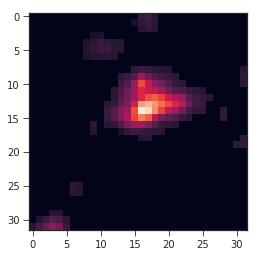

In [64]:
# last week's example image
visualize_viirs(90.1959352984, 22.6341331408)

In [65]:
diameter = 14
for i, idx in enumerate(bangladesh_2015.index):
  lat = bangladesh_2015["lat1"][idx]
  lng = bangladesh_2015["long1"][idx]
  if np.isnan(lat) or np.isnan(lng):
    print("Cannot locate row {}".format(idx))
    continue
  x, y = viirs_props.lonlat2colrow(lng, lat)
  patch = viirs_tif.ReadAsArray(x - diameter // 2, y - diameter // 2, diameter, diameter)
  if patch is None:
    print("No entry for row {}".format(idx))
  else:
    viirs_night_intensities["bangladesh"][i] = np.mean(patch)

Cannot locate row 1659
Cannot locate row 2087
No entry for row 2433
No entry for row 5062
No entry for row 5327
No entry for row 5369
No entry for row 5416
No entry for row 5429


In [66]:
bangladesh_2015["viirs"] = viirs_night_intensities["bangladesh"]

In [67]:
bangladesh_2015["viirs"].corr(bangladesh_2015["totexp_m_pc"])

0.051041197425078531

In [68]:
group_level = "Village"

In [69]:
light = bangladesh_2015.groupby(group_level)["viirs"].mean()
expen = bangladesh_2015.groupby(group_level)["totexp_m_pc"].mean()
expen.corr(light)

0.17021135619472927

In [70]:
diameter = 14
for i, idx in enumerate(india.index):
  lat = india["latitude"][idx]
  lng = india["longitude"][idx]
  if np.isnan(lat) or np.isnan(lng):
    continue
  x, y = viirs_props.lonlat2colrow(lng, lat)
  patch = viirs_tif.ReadAsArray(x - diameter // 2, y - diameter // 2, diameter, diameter)
  if patch is None:
    pass
  else:
    viirs_night_intensities["india"][i] = np.mean(patch)

In [71]:
india["viirs"] = viirs_night_intensities["india"]

In [72]:
india["viirs"].corr(india["secc_cons_per_cap_scaled"])

0.11488475482049819

**DMSP dataset**

Resolution: 30 arc-seconds.

Date: 2013

In [73]:
lights_tif = "../data/bucket/F182013.v4c_web.stable_lights.avg_vis.tif"

In [74]:
dmsp_tif = gdal.Open(lights_tif)

In [75]:
dmsp_props = GeoProps()
dmsp_props.import_geogdal(dmsp_tif)

In [76]:
dmsp_night_intensities = {
  "india": np.zeros(len(india)),
  "bangladesh": np.zeros(len(bangladesh_2015)),
}

In [77]:
diameter = 7
for i, idx in enumerate(bangladesh_2015.index):
  lat = bangladesh_2015["lat1"][idx]
  lng = bangladesh_2015["long1"][idx]
  if np.isnan(lat) or np.isnan(lng):
    print("Cannot locate row {}".format(idx))
    continue
  x, y = dmsp_props.lonlat2colrow(lng, lat)
  patch = dmsp_tif.ReadAsArray(x - diameter // 2, y - diameter // 2, diameter, diameter)
  if patch is None:
    print("No entry for row {}".format(idx))
  else:
    dmsp_night_intensities["bangladesh"][i] = np.mean(patch)

Cannot locate row 1659
Cannot locate row 2087


In [78]:
bangladesh_2015["dmsp"] = dmsp_night_intensities["bangladesh"]

In [79]:
bangladesh_2015["dmsp"].corr(bangladesh_2015["totexp_m_pc"])

0.075727270971530064

In [80]:
light = bangladesh_2015.groupby(group_level)["dmsp"].mean()
expen = bangladesh_2015.groupby(group_level)["totexp_m_pc"].mean()
expen.corr(light)

0.27520732611163973

In [81]:
def plot_nightlight_vs_exp(expen, light):
  """
  Plot expenditures vs night lights
  """
  fig = sns.jointplot(expen, light, kind="reg", size=8, marker=".")
  fig.fig.set_size_inches((12, 8))
  fig.ax_joint.set(ylabel="Night-time light intensity [30 arc meter resolution]",
                   xlabel="log(Monthly household expenditure)")
  fig.ax_joint.set_title("Bangladesh [DMSP]: Night-time light intensity versus monthly household expenditures", y=0.98);

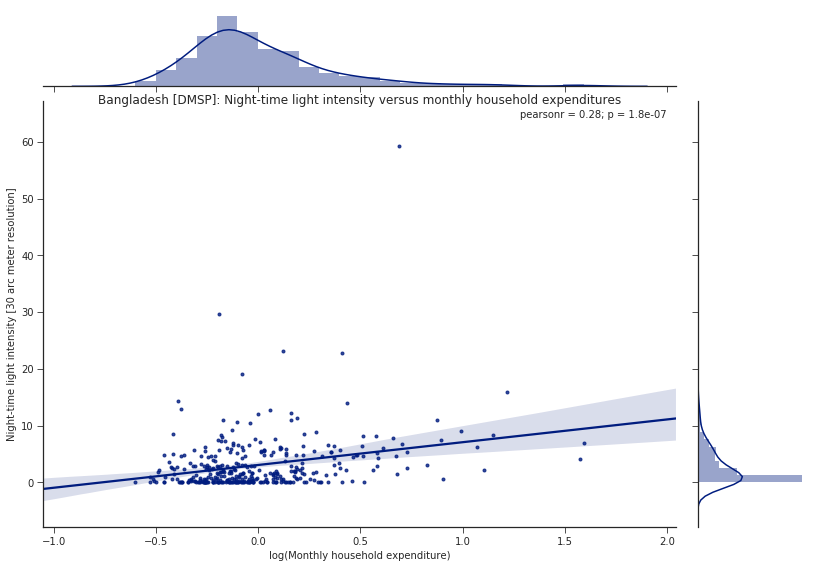

In [82]:
plot_nightlight_vs_exp(expen, light)

In [106]:
diameter = 7
for i, idx in enumerate(india.index):
  lat = india["latitude"][idx]
  lng = india["longitude"][idx]
  if np.isnan(lat) or np.isnan(lng):
    continue
  x, y = dmsp_props.lonlat2colrow(lng, lat)
  patch = dmsp_tif.ReadAsArray(x - diameter // 2, y - diameter // 2, diameter, diameter)
  if patch is None:
    pass
  else:
    dmsp_night_intensities["india"][i] = np.mean(patch)

In [107]:
india["dmsp"] = dmsp_night_intensities["india"]

In [108]:
india["secc_cons_per_cap_scaled"].corr(india["dmsp"])

0.31184270846472489

In [109]:
# india.to_csv("/home/tony/predicting-poverty/data/india_with_nightlights.csv")

**Baseline -- GBM [Bangladesh]**

In [83]:
train_villages = set(bangladesh_2015_train["Village"])
valid_villages = set(bangladesh_2015_valid["Village"])

In [84]:
viirs = bangladesh_2015.groupby(group_level)["viirs"].mean()
dmsp = bangladesh_2015.groupby(group_level)["dmsp"].mean()
expen = bangladesh_2015.groupby(group_level)["totexp_m_pc"].mean()

In [85]:
X_train = pd.concat([
  pd.Series(viirs[train_villages], name="viirs"),
  pd.Series(dmsp[train_villages], name="dmsp"),
], axis=1)

In [86]:
X_valid = pd.concat([
  pd.Series(viirs[valid_villages], name="viirs"),
  pd.Series(dmsp[valid_villages], name="dmsp"),
], axis=1)

In [87]:
y_train = pd.Series(expen[train_villages], name="totexp_m_pc")
y_valid = pd.Series(expen[valid_villages], name="totexp_m_pc")

In [88]:
gbm = GradientBoostingRegressor(loss="ls", n_estimators=150, max_depth=1)

In [89]:
gbm.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=150, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [90]:
gbm.score(X_valid, y_valid)

0.0932219614005243

In [277]:
train_scores, valid_scores = [], []

In [278]:
for alpha in np.logspace(-5, 3, num=20):
  lm = Ridge(alpha=alpha, normalize=True)
  lm.fit(X_train, y_train)
  y_pred = lm.predict(X_train)
  train_scores.append(metrics.r2_score(y_train, y_pred))
  y_pred = lm.predict(X_valid)
  valid_scores.append(metrics.r2_score(y_valid, y_pred))
  print("alpha:", alpha, "\tscore:", valid_scores[-1])

alpha: 1e-05 	score: -1.94400967626
alpha: 2.63665089873e-05 	score: -1.94312970064
alpha: 6.95192796178e-05 	score: -1.9408119379
alpha: 0.000183298071083 	score: -1.93471762659
alpha: 0.000483293023857 	score: -1.91876518886
alpha: 0.0012742749857 	score: -1.87749717005
alpha: 0.00335981828628 	score: -1.77394886478
alpha: 0.0088586679041 	score: -1.53338576779
alpha: 0.0233572146909 	score: -1.06766319927
alpha: 0.0615848211066 	score: -0.45087150049
alpha: 0.162377673919 	score: -0.0249352090465
alpha: 0.428133239872 	score: 0.0865271340952
alpha: 1.12883789168 	score: 0.0859871392577
alpha: 2.97635144163 	score: 0.0712076454427
alpha: 7.84759970351 	score: 0.0446479880321
alpha: 20.6913808111 	score: 0.0211536253252
alpha: 54.5559478117 	score: 0.00820739622199
alpha: 143.844988829 	score: 0.00249526200174
alpha: 379.269019073 	score: 0.000197295976331
alpha: 1000.0 	score: -0.000694163825938


In [286]:
os.mkdir("/home/tony/models/bangladesh_v_gbm")

In [99]:
y_pred = gbm.predict(X_valid)

In [100]:
np.save("/home/tony/models/bangladesh_v_gbm/y_pred.npy", y_pred)
np.save("/home/tony/models/bangladesh_v_gbm/y_true.npy", y_valid)

In [104]:
# bangladesh_2015.to_csv("/home/tony/predicting-poverty/data/bangladesh_with_nightlights.csv")

**Baseline -- GBM [India]**

In [293]:
india_id_to_idx = lambda i: i - 1

In [294]:
X_train = pd.concat([pd.Series(viirs_night_intensities["india"][india_train["id"] - 1]), 
                     pd.Series(dmsp_night_intensities["india"][india_train["id"] - 1])], axis=1)

In [295]:
X_valid = pd.concat([pd.Series(viirs_night_intensities["india"][india_valid["id"] - 1]), 
                     pd.Series(dmsp_night_intensities["india"][india_valid["id"] - 1])], axis=1)

In [296]:
y_train = india_train["secc_cons_per_cap_scaled"]
y_valid = india_valid["secc_cons_per_cap_scaled"]

In [297]:
X_train, y_train = X_train[~np.isnan(y_train)], y_train[~np.isnan(y_train)]

In [298]:
X_valid, y_valid = X_valid[~np.isnan(y_valid)], y_valid[~np.isnan(y_valid)]

In [299]:
gbm = GradientBoostingRegressor(loss="huber", n_estimators=25, max_depth=10)

In [300]:
gbm.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=10,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=25, presort='auto',
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [301]:
gbm.score(X_valid, y_valid)

0.16512969649469

In [302]:
y_pred = gbm.predict(X_valid)

In [306]:
os.mkdir("/home/tony/models/india_gbm/")

In [309]:
np.save("/home/tony/models/india_gbm/y_pred.npy", y_pred)
np.save("/home/tony/models/india_gbm/y_true.npy", y_valid)

In [310]:
train_scores, valid_scores = [], []

In [311]:
for alpha in np.logspace(-6, 3, num=20):
  lm = Ridge(alpha=alpha, normalize=True)
  lm.fit(X_train, y_train)
  y_pred = lm.predict(X_train)
  train_scores.append(metrics.r2_score(y_train, y_pred))
  y_pred = lm.predict(X_valid)
  valid_scores.append(metrics.r2_score(y_valid, y_pred))
  print("alpha:", alpha, "\tscore:", valid_scores[-1])

alpha: 1e-06 	score: 0.105461423886
alpha: 2.97635144163e-06 	score: 0.105461438407
alpha: 8.8586679041e-06 	score: 0.10546148157
alpha: 2.63665089873e-05 	score: 0.10546160954
alpha: 7.84759970351e-05 	score: 0.105461986011
alpha: 0.000233572146909 	score: 0.105463067507
alpha: 0.000695192796178 	score: 0.105465942595
alpha: 0.00206913808111 	score: 0.105471501245
alpha: 0.00615848211066 	score: 0.105462681985
alpha: 0.0183298071083 	score: 0.105240249164
alpha: 0.0545559478117 	score: 0.103402098315
alpha: 0.162377673919 	score: 0.0945678522042
alpha: 0.483293023857 	score: 0.0733120149915
alpha: 1.43844988829 	score: 0.0471593796091
alpha: 4.28133239872 	score: 0.0249100571488
alpha: 12.742749857 	score: 0.0106268922621
alpha: 37.9269019073 	score: 0.00393427386947
alpha: 112.883789168 	score: 0.00136290878588
alpha: 335.981828628 	score: 0.000456287199743
alpha: 1000.0 	score: 0.000146582181087


**Baseline -- HOG/Histograms/Night lights**

In [291]:
def load_tiff(hhid, country="bangladesh", prefix="s1", imgtype="vis", quiet=False):
  """
  hhid:    household index as float [pull from bangladesh_2015 csv]
  prefix:  either "s1" or "l8"
  imgtype: either "vis" or "multiband"
  """
  source_tiff = "../data/bucket/{}_median_{}_{}_500x500_{:.1f}.tif".format(prefix, country, imgtype, hhid)
  if not quiet:
    print("Loading {}...".format(source_tiff))
  gdal_tif = gdal.Open(source_tiff)
  return gdal_tif.ReadAsArray().astype("uint8")

In [35]:
def vis_tif(A):
  plt.imshow(A.transpose(1,2,0))

In [36]:
A = load_tiff(6170.0, prefix="l8", imgtype="vis")

Loading ../data/bucket/l8_median_bangladesh_vis_500x500_6170.0.tif...


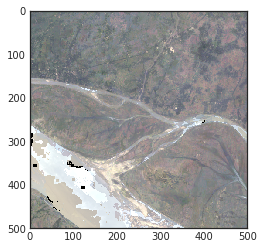

In [37]:
vis_tif(A)

In [38]:
A = load_tiff(6170.0, country="india", prefix="s1", imgtype="vis")

Loading ../data/bucket/s1_median_india_vis_500x500_6170.0.tif...


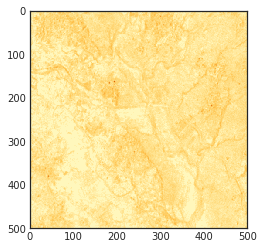

In [39]:
vis_tif(A)

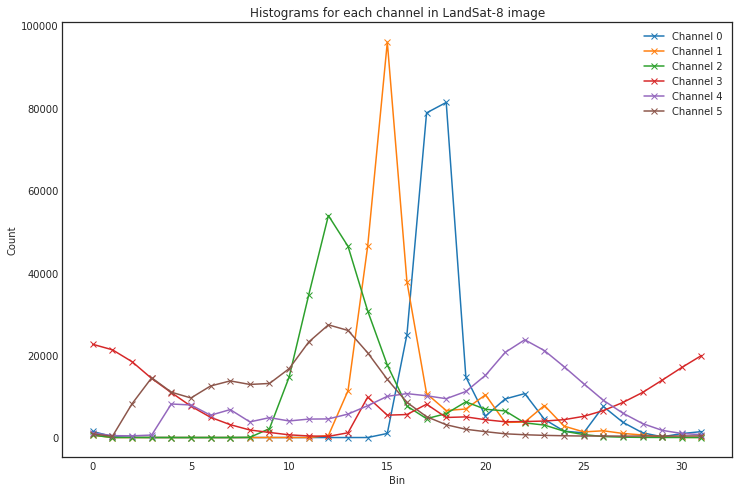

In [233]:
plt.figure(figsize=(12, 8))
for channel_idx in range(6):
  plt.plot(cv2.calcHist(A.astype("uint8"), 
                     channels=[channel_idx], 
                     mask=None, 
                     histSize=[32], 
                     ranges=[0, 256]), "x-", label="Channel {:d}".format(channel_idx))
plt.title("Histograms for each channel in LandSat-8 image")
plt.xlabel("Bin")
plt.ylabel("Count")
plt.legend();

In [219]:
A = load_tiff(6170.0, prefix="s1", imgtype="multiband")

Loading ../data/bucket/s1_median_bangladesh_multiband_500x500_6170.0.tif...


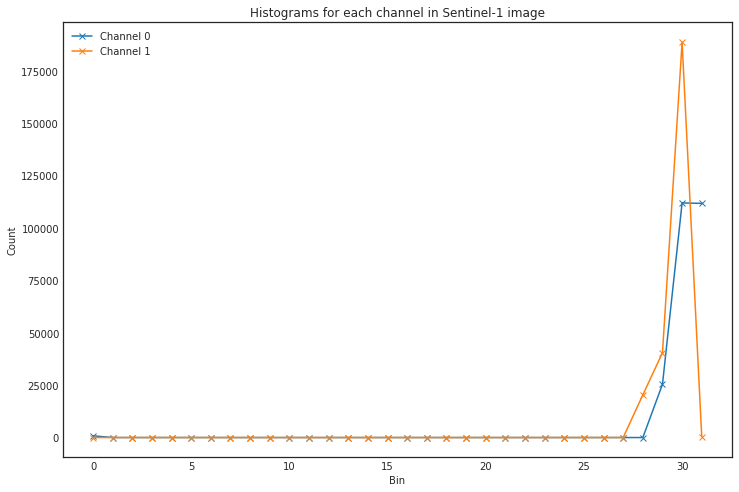

In [588]:
plt.figure(figsize=(12, 8))
for channel_idx in range(2):
  plt.plot(cv2.calcHist(A.astype("uint8"), 
                     channels=[channel_idx], 
                     mask=None, 
                     histSize=[32], 
                     ranges=[0, 256]), "x-", label="Channel {:d}".format(channel_idx))
plt.title("Histograms for each channel in Sentinel-1 image")
plt.xlabel("Bin")
plt.ylabel("Count")
plt.legend();

**Hog features [single-channel]**

In [578]:
A = load_tiff(6170.0, prefix="l8", imgtype="vis")

Loading ../data/bucket/l8_median_bangladesh_vis_500x500_6170.0.tif...


In [579]:
fd = hog(A[0], orientations=8, pixels_per_cell=(16, 16),
        cells_per_block=(1, 1), visualise=True)[0]

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [580]:
fd, hog_image = hog(A[0], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


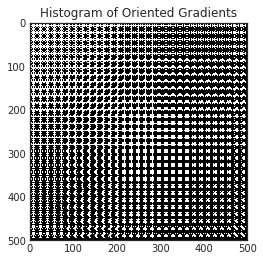

In [581]:
# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

# ax2.axis('off')
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
plt.title('Histogram of Oriented Gradients');

**Histogram of each channel [LandSat-8]**

Note that we use a resolution of 8 pixel values per histogram bin, for a total of 32 bins per image.

In [40]:
l8_channel_hists = [[] for _ in range(6)]
s1_channel_hists = [[] for _ in range(2)]

In [41]:
error_vect = np.zeros(len(bangladesh_2015))

In [42]:
for i, hhid in enumerate(bangladesh_2015["a01"]):
  if i % 100 == 0:
    print("{}/{} errors.".format(sum(error_vect), i))
  try:
    LM = load_tiff(hhid, prefix="l8", country="bangladesh", imgtype="multiband", quiet=True)
    SM = load_tiff(hhid, prefix="s1", country="bangladesh", imgtype="vis", quiet=True)
    for channel_idx in range(6):
      hist = cv2.calcHist(LM.astype("uint8"), 
                          channels=[channel_idx], 
                          mask=None, 
                          histSize=[32], 
                          ranges=[0, 256])
      l8_channel_hists[channel_idx].append(hist / np.sum(hist))
    for channel_idx in range(2):
      hist = cv2.calcHist(SM.astype("uint8"), 
                         channels=[channel_idx], 
                         mask=None, 
                         histSize=[32], 
                         ranges=[0, 256])
      s1_channel_hists[channel_idx].append(hist / np.sum(hist))
#     hogs.append(hog(SM[0], orientations=8, pixels_per_cell=(16, 16),
#                 cells_per_block=(1, 1), visualise=True)[0])
  except:
    error_vect[i] = 1

0.0/0 errors.
0.0/100 errors.
0.0/200 errors.
8.0/300 errors.
53.0/400 errors.
53.0/500 errors.
53.0/600 errors.
53.0/700 errors.
53.0/800 errors.
53.0/900 errors.
85.0/1000 errors.
104.0/1100 errors.
108.0/1200 errors.
128.0/1300 errors.
128.0/1400 errors.
128.0/1500 errors.
159.0/1600 errors.
160.0/1700 errors.
160.0/1800 errors.
160.0/1900 errors.
160.0/2000 errors.
194.0/2100 errors.
194.0/2200 errors.
194.0/2300 errors.
194.0/2400 errors.
196.0/2500 errors.
198.0/2600 errors.
243.0/2700 errors.
245.0/2800 errors.
292.0/2900 errors.
292.0/3000 errors.
310.0/3100 errors.
322.0/3200 errors.
326.0/3300 errors.
326.0/3400 errors.
339.0/3500 errors.
360.0/3600 errors.
361.0/3700 errors.
362.0/3800 errors.
362.0/3900 errors.
362.0/4000 errors.
367.0/4100 errors.
377.0/4200 errors.
399.0/4300 errors.
400.0/4400 errors.
419.0/4500 errors.
420.0/4600 errors.
426.0/4700 errors.
426.0/4800 errors.
426.0/4900 errors.
453.0/5000 errors.
482.0/5100 errors.
510.0/5200 errors.
558.0/5300 errors.
6

In [45]:
error_vect = pd.Series(error_vect)

In [46]:
np.sum(error_vect)

782.0

Construct $X$ and $Y$ data and partition into train/test/valid.

In [47]:
# viirs_night_intensities

In [48]:
# np.hstack(np.hstack(s1_channel_hists)).T[:2000].shape

In [49]:
# viirs_night_intensities["bangladesh"][:2000].shape

In [50]:
# X = np.c_[#np.hstack(np.hstack(l8_channel_hists)).T, 
#           np.hstack(np.hstack(s1_channel_hists)).T[:2000], 
# #           hogs, 
#           viirs_night_intensities["india"][:2000],
#           dmsp_night_intensities["india"][:2000]]

In [51]:
viirs_night_intensities["bangladesh_ungrouped"] = np.zeros(len(bangladesh_2015))

In [52]:
viirs_night_intensities["bangladesh_ungrouped"] = bangladesh_2015["District"].apply(lambda z: viirs_night_intensities["bangladesh_grouped"][district_to_idx[z]])

In [54]:
dmsp_night_intensities["bangladesh_ungrouped"] = bangladesh_2015["District"].apply(lambda z: dmsp_night_intensities["bangladesh_grouped"][district_to_idx[z]])

In [55]:
X = np.c_[np.hstack(np.hstack(l8_channel_hists)).T, 
          np.hstack(np.hstack(s1_channel_hists)).T, 
          np.log(viirs_night_intensities["bangladesh_ungrouped"][error_vect == False]),
          dmsp_night_intensities["bangladesh_ungrouped"][error_vect == False],
          viirs_night_intensities["bangladesh"][error_vect == False],
          dmsp_night_intensities["bangladesh"][error_vect == False]
         ]

In [58]:
X = pd.DataFrame(X)

In [99]:
y = bangladesh_2015[error_vect == False]

In [59]:
X = X.assign(a01=pd.Series(y["a01"]).values)

In [104]:
X = X[y.reset_index()["totexp_m_pc"] > 0]
y = y[y["totexp_m_pc"] > 0]

/home/tony/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [105]:
# np.save("../data/bangladesh_baseline_X.npy", X)
# np.save("../data/bangladesh_baseline_y.npy", y)
# np.save("../data/bangladesh_error_vect.npy", error_vect)

Re-load data frames.

In [141]:
X = np.load("../data/bangladesh_baseline_X.npy")
Y = np.load("../data/bangladesh_baseline_y.npy")

In [142]:
X.shape, Y.shape

((6280, 261), (6280, 6))

In [143]:
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)

In [144]:
X = X.rename(columns={ X.columns[260]: "a01" })

In [145]:
Y = Y.rename(columns={ Y.columns[0]: "a01" })
Y = Y.rename(columns={ Y.columns[1]: "totexp_m_pc" })

In [146]:
Y["totexp_m_pc"] = Y["totexp_m_pc"] 

In [147]:
X_train = X[np.in1d(X["a01"], bangladesh_2015_train["a01"])]
y_train = Y[np.in1d(Y["a01"], bangladesh_2015_train["a01"])]

In [148]:
X_valid = X[np.in1d(X["a01"], bangladesh_2015_valid["a01"])]
y_valid = Y[np.in1d(Y["a01"], bangladesh_2015_valid["a01"])]

In [149]:
y_train = y_train["totexp_m_pc"]
y_valid = y_valid["totexp_m_pc"]

In [150]:
X_train.shape, y_train.shape

((4719, 261), (4719,))

In [151]:
X_valid.shape, y_valid.shape

((1131, 261), (1131,))

In [163]:
train = X.join(bangladesh_2015_train, on="a01", how="inner", lsuffix="left", rsuffix="right")

In [164]:
X_train = train.iloc[:,:261]

In [165]:
y_train = train["totexp_m"]

In [166]:
valid = X.join(bangladesh_2015_valid, on="a01", how="inner", lsuffix="left", rsuffix="right")

In [167]:
X_valid = valid.iloc[:,:261]

In [168]:
y_valid = valid["totexp_m"]

**For Haque -- merge VIIRS lights**

In [165]:
X = X.set_index("a01")

In [124]:
bangladesh_2015_train = bangladesh_2015_train.set_index("a01")
bangladesh_2015_valid = bangladesh_2015_valid.set_index("a01")
bangladesh_2015_test = bangladesh_2015_test.set_index("a01")

In [125]:
bangladesh_2015_train["viirs"] = X.loc[bangladesh_2015_train.index][258]
bangladesh_2015_valid["viirs"] = X.loc[bangladesh_2015_valid.index][258]
bangladesh_2015_test["viirs"] = X.loc[bangladesh_2015_test.index][258]

In [126]:
bangladesh_2015_train.to_csv("../data/bangladesh_2015_train.csv")
bangladesh_2015_valid.to_csv("../data/bangladesh_2015_valid.csv")
bangladesh_2015_test.to_csv("../data/bangladesh_2015_test.csv")

In [212]:
X_train = X_train[y_train > 0]
y_train = y_train[y_train > 0]

In [213]:
X_valid = X_valid[y_valid > 0]
y_valid = y_valid[y_valid > 0]

Ridge regression: hyperparameter search.

In [179]:
X_train = X_train.iloc[:,259:261]

In [184]:
X_valid = X_valid.iloc[:,259:261]

In [185]:
train_scores, valid_scores = [], []

In [186]:
for alpha in np.logspace(-5, 5, num=20):
  lm = Ridge(alpha=alpha, normalize=True)
  lm.fit(X_train, y_train)
  y_pred = lm.predict(X_train)
  train_scores.append(metrics.r2_score(y_train, y_pred))
  y_pred = lm.predict(X_valid)
  valid_scores.append(metrics.r2_score(y_valid, y_pred))
  print("alpha:", alpha, "\tscore:", valid_scores[-1])

alpha: 1e-05 	score: -0.00398185031979
alpha: 3.35981828628e-05 	score: -0.00398179445454
alpha: 0.000112883789168 	score: -0.00398160682119
alpha: 0.000379269019073 	score: -0.00398097712559
alpha: 0.0012742749857 	score: -0.00397886954003
alpha: 0.00428133239872 	score: -0.00397187841336
alpha: 0.0143844988829 	score: -0.00394936159652
alpha: 0.0483293023857 	score: -0.00388324423072
alpha: 0.162377673919 	score: -0.00373251323663
alpha: 0.545559478117 	score: -0.00352614532985
alpha: 1.83298071083 	score: -0.0033755194557
alpha: 6.15848211066 	score: -0.00330540722668
alpha: 20.6913808111 	score: -0.00327990572714
alpha: 69.5192796178 	score: -0.00327173444814
alpha: 233.572146909 	score: -0.00326924422272
alpha: 784.759970351 	score: -0.00326849769356
alpha: 2636.65089873 	score: -0.00326827502088
alpha: 8858.6679041 	score: -0.00326820870305
alpha: 29763.5144163 	score: -0.00326818896076
alpha: 100000.0 	score: -0.00326818308442


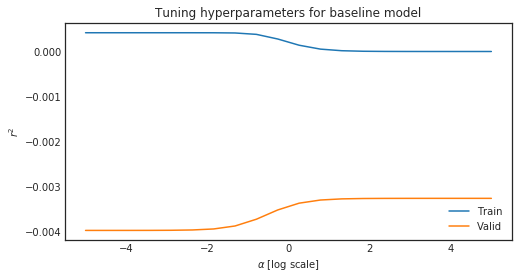

In [187]:
plt.figure(figsize=(8, 4))
plt.plot(np.linspace(-5, 5, num=20), train_scores, label="Train")
plt.plot(np.linspace(-5, 5, num=20), valid_scores, label="Valid")
plt.title("Tuning hyperparameters for baseline model")
plt.ylabel("$r^2$")
plt.xlabel("$\\alpha$ [log scale]")
plt.legend();

In [195]:
bangladesh_2015_train[bangladesh_2015_train["totexp_m_pc"] > 100]

,a01,Unnamed: 0,aeu,totexp_m,hh_type,div,District,lat1,long1,totexp_m_pc,viirs
47,44.0,47,0.61,73.996720,2,40,1,22.477500,90.164444,121.306095,0.000000
655,694.0,717,0.61,71.670508,3,20,13,23.363889,91.065278,117.492633,1.694610
1031,1093.1,1134,0.61,82.016040,3,20,19,23.952222,91.195278,134.452522,1.470530
2932,3768.0,3894,0.83,124.829414,3,30,68,24.242222,90.825833,150.396887,1.009057
3134,4082.0,4218,0.83,106.378767,3,20,75,23.198056,91.000833,128.167191,0.441516
3950,5122.0,5288,0.83,146.214298,3,60,91,24.835833,91.751667,176.161808,0.625036


In [216]:
bangladesh_2015[bangladesh_2015["a01"] == 44.0]

,a01,aeu,totexp_m,hh_type,div,District,lat1,long1,totexp_m_pc
47,44.0,0.61,6098.809633,2,40,1,22.4775,90.164444,9998.048345


In [228]:
X.iloc[:,259].corr(Y["totexp_m_pc"])

0.081718619430424577

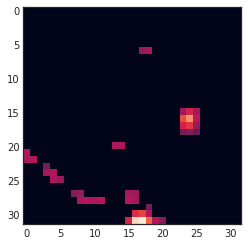

In [208]:
visualize_viirs(90.164444, 22.477500)

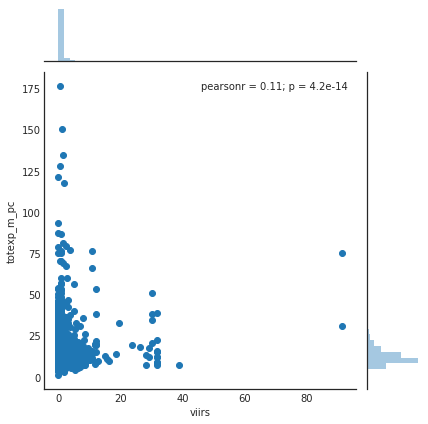

In [190]:
sns.jointplot(bangladesh_2015_train["viirs"], bangladesh_2015_train["totexp_m_pc"])

In [70]:
lm = Ridge(alpha=0.297635144163, normalize=True)
lm.fit(X_train, y_train)

Ridge(alpha=0.297635144163, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [72]:
lm.score(X_valid, y_valid)

-0.016811886991722647

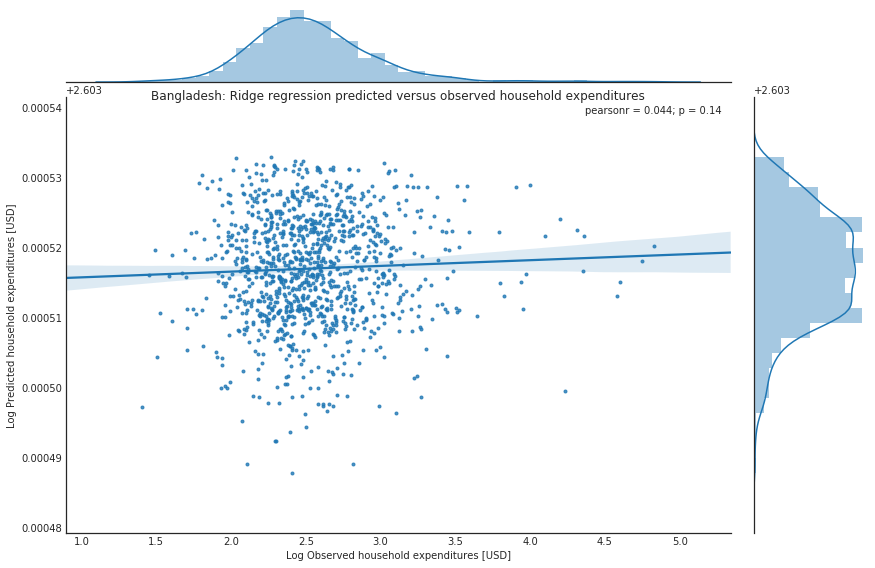

In [73]:
fig = sns.jointplot(np.log(y_valid[np.logical_and(y_valid > 0, y_pred > 0)]), 
                    np.log(y_pred[np.logical_and(y_valid > 0, y_pred > 0)]), 
                    kind="reg", size=8, marker=".")
fig.fig.set_size_inches((12, 8))
fig.ax_joint.set(ylabel="Log Predicted household expenditures [USD]",
                 xlabel="Log Observed household expenditures [USD]")
fig.ax_joint.set_title("Bangladesh: Ridge regression predicted versus observed household expenditures", y=0.98);

Lasso regression.

In [90]:
lm = Lasso(alpha=1200.0)

In [91]:
lm.fit(X_train, y_train)

Lasso(alpha=1200.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [92]:
lm.score(X_train, y_train)

0.011806416142204013

In [93]:
lm.score(X_valid, y_valid)

-0.040707351071601179

In [94]:
y_pred = lm.predict(X_valid)

In [95]:
np.sqrt(np.mean(np.square(y_pred - y_valid)))

56.873327627328386

Random forest regression.

In [558]:
rf = RandomForestRegressor(criterion="mse", max_depth=12, n_estimators=50, n_jobs=4)

In [559]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [180]:
rf.score(X_train, y_train)

0.8013085528083016

In [181]:
rf.score(X_valid, y_valid)

0.077254831443688943

In [448]:
y_pred = rf.predict(X_valid)

In [449]:
np.sqrt(np.mean(np.square(y_pred - y_valid)))

5182.123913879178